# Project

In [101]:
import numpy as np
import pandas as pd 
import math
from random import gauss
from math import sqrt
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from math import log, sqrt, exp
from scipy.stats import norm
from glob import glob
from sklearn import linear_model
#from sklearn.linear_model import LinearRegression
import warnings
import os
from functools import reduce
warnings.filterwarnings("ignore")

# Data Acquisition and Cleaning - 10 years daily from NASDAQ 100 Technology Sector 

In [102]:
# function for reading files
def read_file(f):
    df = pd.read_csv(f)
    df['ticker'] = f.split('.')[0].strip('^')
    return df

# function for getting log-returns
def getlogret(data):
    logret = np.log(data) - np.log(data.shift(1))
    return logret

In [103]:
# create the dataframe for closing price, named as 'close'
close = pd.concat([read_file(f) for f in glob('*.csv')])
close = close.set_index(['Date','ticker'])[['Close']].unstack()
# extract the tickers for renaming purpose later
tickers = close.columns.get_level_values('ticker')
close1 = close
close1.columns = tickers
close1 = close1.drop(['IXIC', 'NDXT'], axis=1)
close.describe()

ticker,AAPL,AMD,BIDU,GOOGL,IXIC,MSFT,NDXT,NVDA,NXPI,QCOM,SWKS,TXN
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000
mean,40.961873,18.269491,166.567751,847.299840,5968.584892,81.667929,3227.884295,131.356272,81.950731,70.503307,74.384801,76.105727
std,30.015165,23.802609,48.270518,456.241441,2760.334347,60.718786,1774.273172,155.453425,41.898390,22.154399,40.970298,41.237771
min,11.261429,1.620000,83.589996,237.677673,2335.830078,23.709999,1121.739990,11.380000,13.680000,42.959999,14.040000,24.820000
25%,21.147053,3.650000,125.045002,513.917679,3999.397460,36.462500,1811.422486,15.847500,42.470000,56.697501,28.855000,42.305001
50%,29.445000,6.985000,165.459999,762.064972,5098.590088,54.815000,2416.324951,45.815001,87.015000,65.134998,77.274998,60.535000
75%,47.576249,22.475000,200.340004,1133.414978,7576.662353,108.325003,4319.229858,203.209999,107.830000,74.730003,99.349998,108.579998
max,143.160004,97.250000,339.910004,2392.760010,14138.780273,261.970001,8480.860352,649.780029,214.699997,164.779999,199.660004,196.929993


In [104]:
tickers

Index(['AAPL', 'AMD', 'BIDU', 'GOOGL', 'IXIC', 'MSFT', 'NDXT', 'NVDA', 'NXPI',
       'QCOM', 'SWKS', 'TXN'],
      dtype='object', name='ticker')

In [105]:
# create the dataframe for logreturns, named as 'logret'
logret = close
for i in range(0,len(close.axes[1])):
    logret.iloc[:,i] = getlogret(close.iloc[:,i])
logret = logret.iloc[1:].rename(columns={'Close': 'Logret'})
#print(logret)

In [106]:
logret = logret.round(20)
#print(logret)

# Data Analysis - use the historical data to predict the future

## Volatility 

In [107]:
# Define functions for actual/predicted volatility and the absolute error between them

def volpred(df, n):
    # keep the index for non-overlapped rolling window. eg for a=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], a[2::3]=[2, 5, 8]
    return (df.rolling(n).std()[n-1::n])*np.sqrt(260) # change to annualized volatility

def volerr(df, n):
    df_volpred = volpred(df, n) 
    df_volerr = df_volpred.shift(-1) - df_volpred
    df_volerr = df_volerr.iloc[:-1] # delete the last NaN row
    df_volerr.columns = pd.MultiIndex.from_product([['Residual Error (Volatility)'], tickers])
    return df_volerr

def volabserr(df, n):
    df_volpred = volpred(df, n)
    df_volabserr = (df_volpred.shift(-1) - df_volpred).abs()
    df_volabserr = df_volabserr.iloc[:-1] # delete the last NaN row
    df_volabserr.columns = pd.MultiIndex.from_product([['Absolute Error (Volatility)'], tickers])
    return df_volabserr

In [110]:
len(volpred(logret, 150))

16

           Absolute Error (Volatility)                                \
ticker                            AAPL       AMD      BIDU     GOOGL   
Date                                                                   
2011-06-29                    0.030385  0.439595  0.190076  0.290435   
2011-07-28                    0.243041  0.020927  0.332403  0.017542   
2011-08-25                    0.217831  0.142134  0.168390  0.240374   
2011-09-23                    0.132983  0.227443  0.119803  0.116461   
2011-10-21                    0.105270  0.049179  0.101621  0.110202   
...                                ...       ...       ...       ...   
2020-12-11                    0.123520  0.004299  0.591956  0.015726   
2021-01-12                    0.021735  0.065007  0.381499  0.187226   
2021-02-10                    0.047283  0.139023  0.488149  0.090274   
2021-03-11                    0.112800  0.205605  0.267474  0.060540   
2021-04-09                    0.030728  0.120842  0.491014  0.05

(None,
 array([[<AxesSubplot:title={'center':"('Absolute Error (Volatility)', 'AAPL')"}>,
         <AxesSubplot:title={'center':"('Absolute Error (Volatility)', 'AMD')"}>,
         <AxesSubplot:title={'center':"('Absolute Error (Volatility)', 'BIDU')"}>],
        [<AxesSubplot:title={'center':"('Absolute Error (Volatility)', 'GOOGL')"}>,
         <AxesSubplot:title={'center':"('Absolute Error (Volatility)', 'IXIC')"}>,
         <AxesSubplot:title={'center':"('Absolute Error (Volatility)', 'MSFT')"}>],
        [<AxesSubplot:title={'center':"('Absolute Error (Volatility)', 'NDXT')"}>,
         <AxesSubplot:title={'center':"('Absolute Error (Volatility)', 'NVDA')"}>,
         <AxesSubplot:title={'center':"('Absolute Error (Volatility)', 'NXPI')"}>],
        [<AxesSubplot:title={'center':"('Absolute Error (Volatility)', 'QCOM')"}>,
         <AxesSubplot:title={'center':"('Absolute Error (Volatility)', 'SWKS')"}>,
         <AxesSubplot:title={'center':"('Absolute Error (Volatility)', 'TXN')

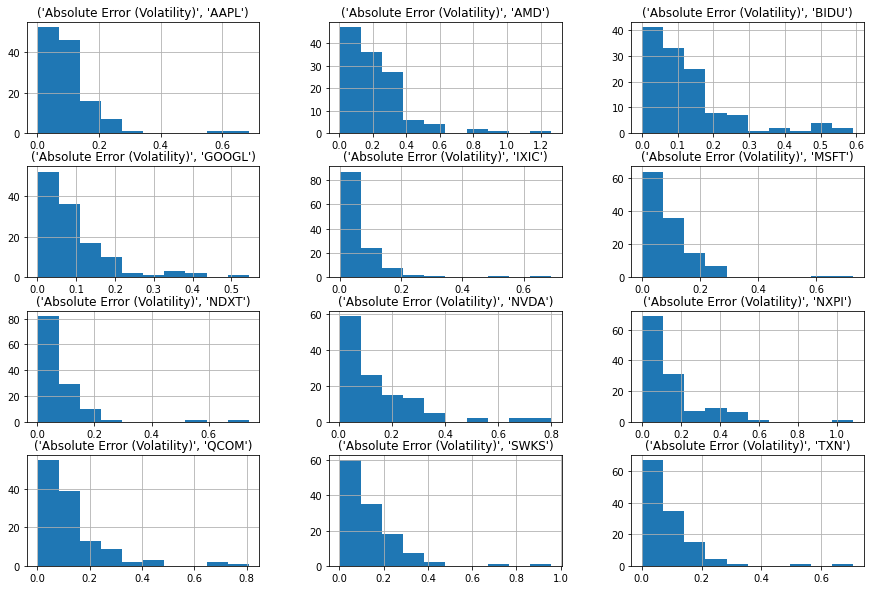

In [84]:
plothist(volabserr, 20)

Text(0.5, 0.89, 'Predicted Volatility')

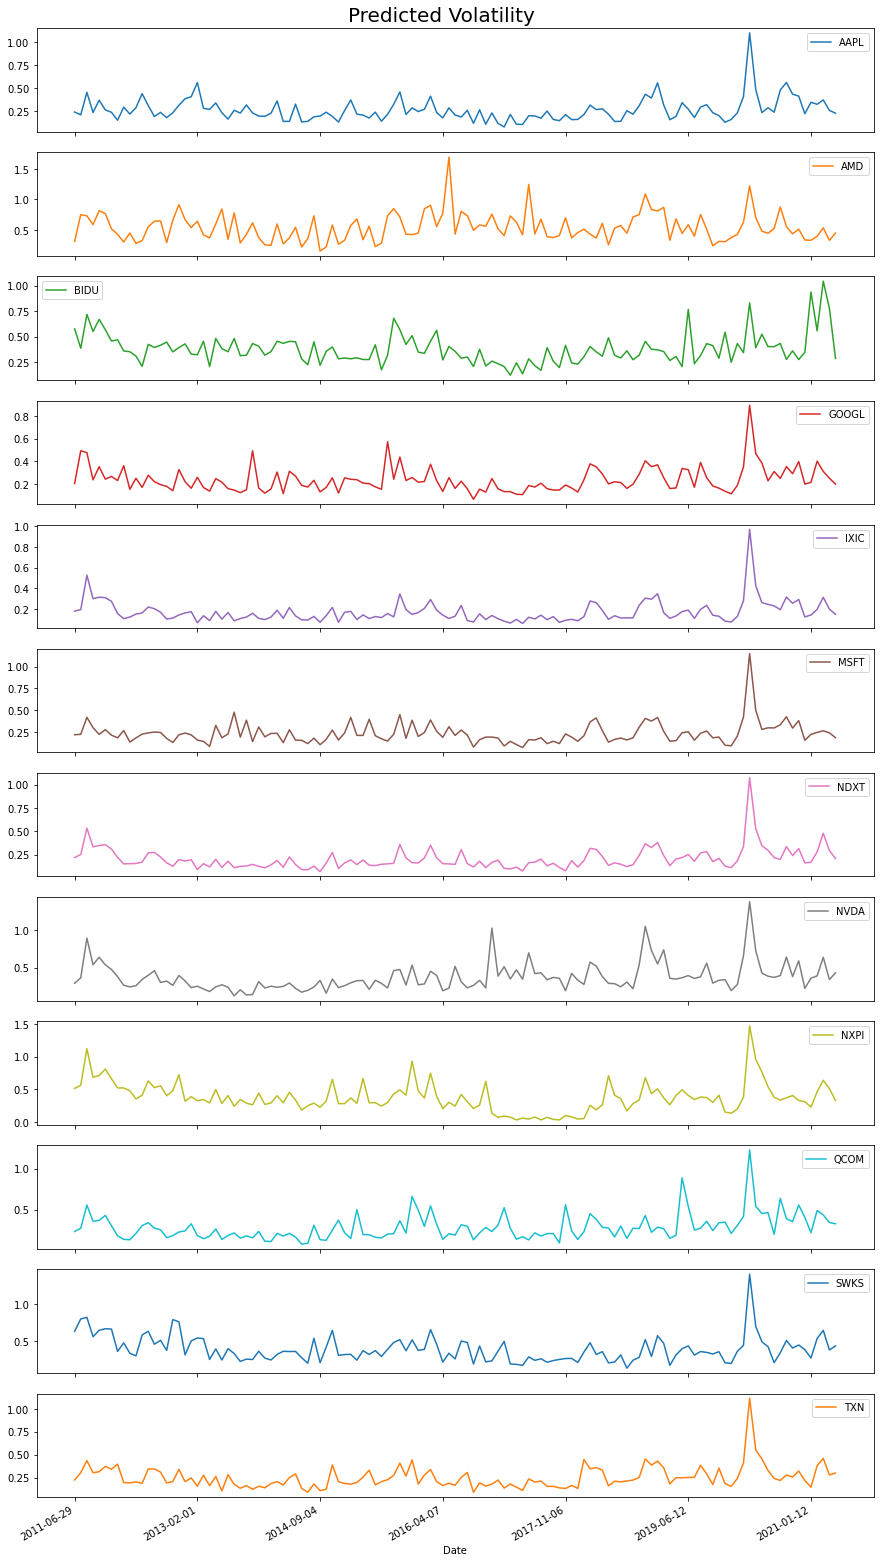

In [58]:
volpred(logret, 20).plot(figsize = (15,30), subplots=True)
plt.suptitle("Predicted Volatility", fontsize = 20, y = 0.89)

In [59]:
# Define error functions, relative errors, taking size of error into account

def volAPE(df,n): # use absolute percentage error
    df_volpred = volpred(df, n)
    df_volact = df_volpred.shift(-1)
    df_volerr = (df_volpred - df_volact).iloc[:-1]  # delete the last NaN row
    df_volpred.columns = tickers
    df_volact.columns = tickers
    df_volerr.columns = tickers
    df_volAPE = (df_volerr.div(df_volact.iloc[:-1])).abs() # abs((actual-pred)/actual) 
    df_volAPE.columns=pd.MultiIndex.from_product([['APE (Volatility)'], df_volAPE.columns])
    return df_volAPE

def volAMPE(df,n): # use absolute mean percentage error
    df_volpred = volpred(df, n)
    df_volact = df_volpred.shift(-1)
    df_volerr = (df_volpred - df_volact).iloc[:-1]  # delete the last NaN row
    df_volpred.columns = tickers
    df_volact.columns = tickers
    df_volerr.columns = tickers
    avg = (df_volact.iloc[:-1] + df_volpred.iloc[:-1]) / 2   # exclude the last NaN rows
    df_volAMPE = (df_volerr.div(avg)).abs() # abs((actual-pred)/avg)
    df_volAMPE.columns=pd.MultiIndex.from_product([['AMPE (Volatility)'], df_volAMPE.columns])
    return df_volAMPE

## Mean 

In [85]:
# Define functions for actual/predicted mean and the absolute error between them

def meanpred(df, n):
    return (df.rolling(n).mean()[n-1::n])*260 # change to annualized mean

def meanerr(df, n):
    df_meanpred = meanpred(df, n)
    df_meanerr = (df_meanpred.shift(-1) - df_meanpred)
    df_meanerr = df_meanerr.iloc[:-1] # delete the last NaN row
    df_meanerr.columns=pd.MultiIndex.from_product([['Residual Error (Mean)'], tickers])
    return df_meanerr 

def meanabserr(df, n):
    df_meanpred = meanpred(df, n)
    df_meanabserr = (df_meanpred.shift(-1) - df_meanpred).abs()
    df_meanabserr = df_meanabserr.iloc[:-1] # delete the last NaN row
    df_meanabserr.columns=pd.MultiIndex.from_product([['Absolute Error (Mean)'], tickers])
    return df_meanabserr

           AMPE (Mean)                                                         \
ticker            AAPL        AMD       BIDU      GOOGL       IXIC       MSFT   
Date                                                                            
2011-06-29    3.073640   4.460530   1.151304   3.456993  37.231254   0.494203   
2011-07-28    3.685427   5.777568  18.942608  16.588633   2.300537   9.530339   
2011-08-25    8.033633   1.308313   0.787158   2.277859   2.961547   2.782969   
2011-09-23    4.295568   1.574361   1.528581   1.670564   0.796055   1.211858   
2011-10-21    0.478419   6.898507   3.432309   1.761045   4.824405  31.771324   
...                ...        ...        ...        ...        ...        ...   
2020-12-11    0.630579   0.961831   1.046538  25.481883   0.016474  15.164537   
2021-01-12    0.019568  18.861527   0.493784   2.526130   0.197927   1.759636   
2021-02-10    5.657742   1.200034   5.414542   1.858451   8.805319   2.964917   
2021-03-11   21.461927   2.6

(None,
 array([[<AxesSubplot:title={'center':"('AMPE (Mean)', 'AAPL')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'AMD')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'BIDU')"}>],
        [<AxesSubplot:title={'center':"('AMPE (Mean)', 'GOOGL')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'IXIC')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'MSFT')"}>],
        [<AxesSubplot:title={'center':"('AMPE (Mean)', 'NDXT')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'NVDA')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'NXPI')"}>],
        [<AxesSubplot:title={'center':"('AMPE (Mean)', 'QCOM')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'SWKS')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'TXN')"}>]],
       dtype=object))

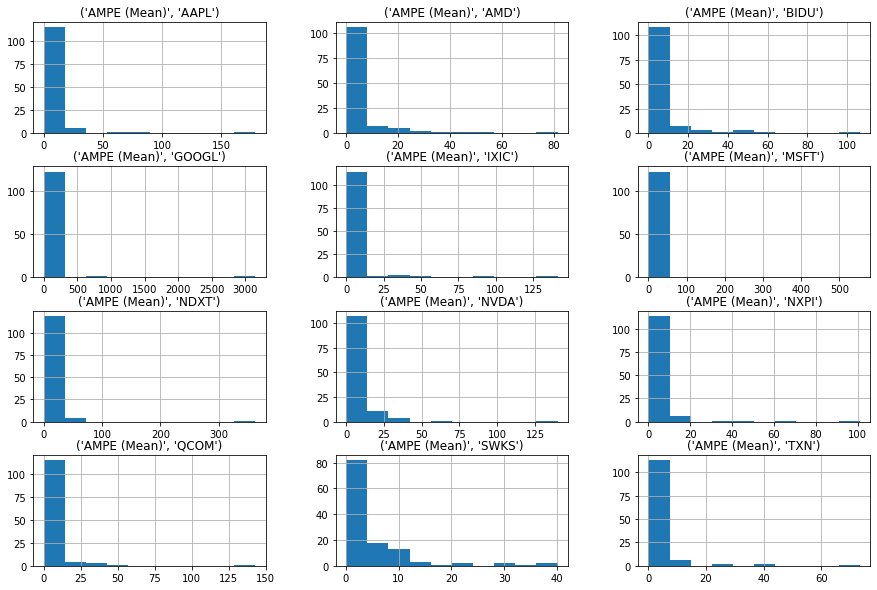

In [89]:
plothist(meanAMPE, 20)

Text(0.5, 0.89, 'Predicted Mean')

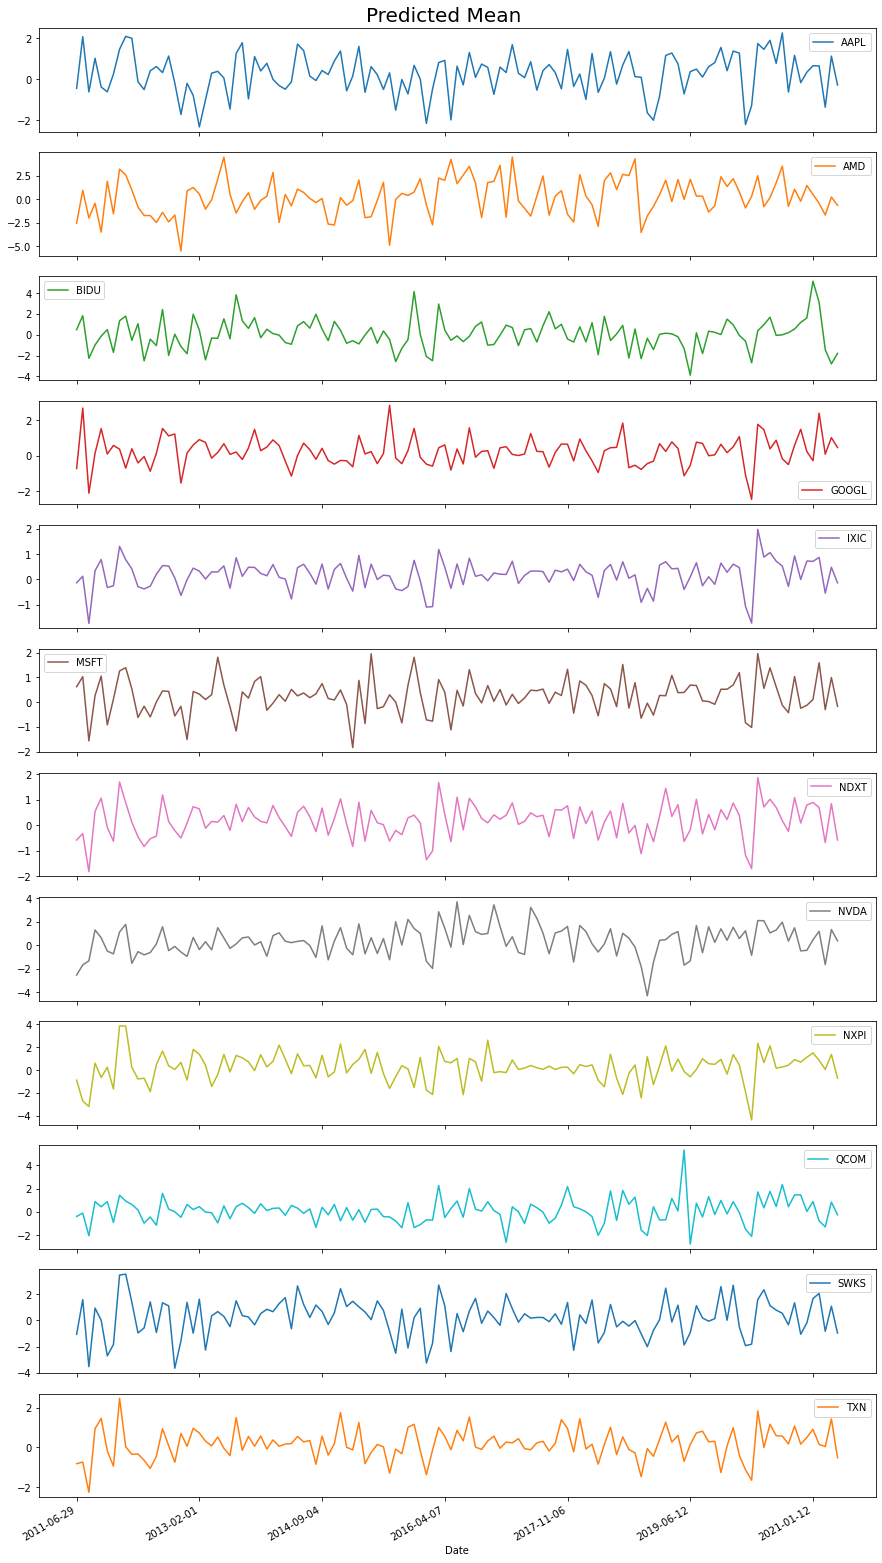

In [61]:
meanpred(logret, 20).plot(figsize = (15,30), subplots=True)
plt.suptitle("Predicted Mean", fontsize = 20, y = 0.89)

In [62]:
# Define error functions, relative errors, taking size of error into account

def meanAPE(df,n): # use absolute percentage error
    df_meanpred = meanpred(df, n)
    df_meanact = df_meanpred.shift(-1)
    df_meanerr = (df_meanpred - df_meanact).iloc[:-1]  # delete the last NaN row
    df_meanpred.columns = tickers
    df_meanact.columns = tickers
    df_meanerr.columns = tickers
    df_meanAPE = (df_meanerr.div(df_meanact.iloc[:-1])).abs() # abs((actual-pred)/actual) 
    df_meanAPE.columns=pd.MultiIndex.from_product([['APE (Mean)'], df_meanAPE.columns])
    return df_meanAPE

def meanAMPE(df,n): # use absolute mean percentage error
    df_meanpred = meanpred(df, n)
    df_meanact = df_meanpred.shift(-1)
    df_meanerr = (df_meanpred - df_meanact).iloc[:-1]  # delete the last NaN row
    df_meanpred.columns = tickers
    df_meanact.columns = tickers
    df_meanerr.columns = tickers
    avg = (df_meanact.iloc[:-1] + df_meanpred.iloc[:-1]) / 2   # exclude the last NaN rows
    df_meanAMPE = (df_meanerr.div(avg)).abs() # abs((actual-pred)/avg)
    df_meanAMPE.columns=pd.MultiIndex.from_product([['AMPE (Mean)'], df_meanAMPE.columns])
    return df_meanAMPE

In [63]:
# define functions for plotting histogram and the numerical results
# given the error functions and a fixed timewindow
def plothist(function, tw):
    myerr = function(logret, tw)
    fig = plt.figure(figsize = (15,10))
    ax = fig.gca()
    errplot = myerr.hist(ax = ax)
    errvalue = print(myerr)
    return errvalue, errplot

### Iterate through the time window

In [64]:
# # define functions for printing the numerical results and plotting the dot graphs
# given the error functions, starting&ending timewindow with step size, tail

# for volatility
def plotdot(function, tw1, tw2, step, tail):
    
    # create a NaN dataframe with rows as the time window, columns as the securities
    col_names = [i for i in range(tw1, tw2+step, step)] # timewindow
    # generate NaN entries
    data = np.empty((close.shape[1], len(col_names))) # number of rows = number of securities
    # create dataframe
    data[:] = np.nan
    dfnan = pd.DataFrame(data, columns=col_names)
    
    # fill in the NaN dataframe with the percentage of error observations in tail
    percent = dfnan
    j = 0
    tw_inf = [] # mark the timewindows for which the errors include +/-inf 
    tw_null = [] # mark the timewindows for which the errors include NaN 
    
    for i in range(tw1, tw2+step, step):
        myerr = function(logret, i)
        
        # check infinity problem
        if myerr.isin([np.inf, -np.inf]).values.any() == True :
            tw_inf.append(i)
        else :
            tw_inf = tw_inf            
        # check NaN problem
        if myerr.isnull().values.any() == True :
            tw_null.append(i)
        else :
            tw_null = tw_null
            
        # create df 'outlier' consists of T/F, T if abs err>tail
        outlier = myerr > tail
        # fill in values representing the percentage of abs error outside tail
        # outlier.mean() calculates percentage of T values 
        percent.iloc[:,j] = outlier.mean().reset_index(drop=True) 
        j = j+1
    
    percent_T = percent.transpose() # exchange x and y axis for plotting purpose
    percent_T.columns = tickers # rename the columns as the securities
    med = percent_T.median(axis=1)
    avg = percent_T.mean(axis=1)
    dotvalue = percent_T
    msg_inf = print(f"Inf error exists when time window = {tw_inf}")
    msg_null = print(f"NaN exists when time window = {tw_null}")
    
    # plot the dot chart
    funcname = str(function.__name__)
    if 'vol' in funcname:
        dotplot = percent_T.plot(ls = '', marker = '.', figsize = (10,5), title = f"Volatility, Percentage of error observations greater than tail={tail}, {funcname.strip('vol')}")
    else:
        dotplot = percent_T.plot(ls = '', marker = '.', figsize = (10,5), title = f"Mean, Percentage of error observations greater than tail={tail}, {funcname.strip('mean')}")
    dotplot_med = med.plot(ls = '-', marker = 'o', figsize = (10,5), label = "median")
    dotplot_avg = avg.plot(ls = '-', marker = 'o', figsize = (10,5), label = "average")
    dotplot.legend(bbox_to_anchor = (1.2, 1))
    return msg_inf, msg_null, dotvalue, dotplot

In [65]:
# define function for dot plot of r-squared from regression between actual and prediction
def plotr2(func_pred, tw1, tw2, step):
    
    # create a NaN dataframe with rows as the time window, columns as the securities
    col_names = [i for i in range(tw1, tw2+step, step)] # timewindow
    # generate NaN entries
    data = np.empty((close.shape[1], len(col_names))) # number of rows = number of securities
    # create dataframe
    data[:] = np.nan
    dfnan = pd.DataFrame(data, columns=col_names)
    
    # fill in the NaN dataframe with r-squared values
    df_r2 = dfnan
    j = 0
    tw_inf = [] # mark the timewindows for which the errors include +/-inf 
    tw_null = [] # mark the timewindows for which the errors include NaN 
    
    for i in range(tw1, tw2+step, step):
        df_pred = func_pred(logret, i)
        df_act = df_pred.shift(-1).iloc[:-1]
        df_pred = df_pred.iloc[:-1]
        
        for k in range(0, len(close.columns), 1):
            # reshape the values of x(actual) and y(prediction) to (length,1) to use sklearn
            act = df_act.iloc[:,k].values.reshape(len(df_act.iloc[:,k]), 1)
            pred = df_pred.iloc[:,k].values.reshape(len(df_pred.iloc[:,k]), 1)
            md = linear_model.LinearRegression()
            md.fit(act, pred)
            r2 = md.score(act, pred)
            # fill in r2 into df_r2
            df_r2.iloc[k,j] = r2
        
        j = j+1
        
        # check infinity problem
        if df_pred.isin([np.inf, -np.inf]).values.any() == True :
            tw_inf.append(i)
        else :
            tw_inf = tw_inf            
        # check NaN problem
        if df_pred.isnull().values.any() == True :
            tw_null.append(i)
        else :
            tw_null = tw_null

    
    df_r2_T = df_r2.transpose() # exchange x and y axis for plotting purpose
    df_r2_T.columns = tickers # rename the columns as the securities
    med = df_r2_T.median(axis=1)
    avg = df_r2_T.mean(axis=1)
    dotvalue = df_r2_T
    msg_inf = print(f"Inf error exists when time window = {tw_inf}")
    msg_null = print(f"NaN exists when time window = {tw_null}")
    
    # plot the dot chart
    funcname = str(func_pred.__name__)
    if 'vol' in funcname:
        dotplot = df_r2_T.plot(ls = '', marker = '.', figsize = (10,5), title = f"Volatility, R-squared from regression between actual and prediction")
    else:
        dotplot = df_r2_T.plot(ls = '', marker = '.', figsize = (10,5), title = f"Mean, R-squared from regression between actual and prediction")
    dotplot_med = med.plot(ls = '-', marker = 'o', figsize = (10,5), label = "median")
    dotplot_avg = avg.plot(ls = '-', marker = 'o', figsize = (10,5), label = "average")
    dotplot.legend(bbox_to_anchor = (1.2, 1))
    return msg_inf, msg_null, dotvalue, dotplot, dotplot_med, dotplot_avg

## Compute results for volatility & mean

ticker          AAPL       AMD      BIDU     GOOGL      IXIC      MSFT  \
Date                                                                     
2011-06-29 -0.030385  0.439595 -0.190076  0.290435  0.014222  0.004616   
2011-07-28  0.243041 -0.020927  0.332403 -0.017542  0.332145  0.195061   
2011-08-25 -0.217831 -0.142134 -0.168390 -0.240374 -0.227097 -0.118478   
2011-09-23  0.132983  0.227443  0.119803  0.116461  0.014857 -0.076855   
2011-10-21 -0.105270 -0.049179 -0.101621 -0.110202 -0.004775  0.054458   
...              ...       ...       ...       ...       ...       ...   
2020-12-11  0.123520 -0.004299  0.591956  0.015726  0.018395  0.068285   
2021-01-12 -0.021735  0.065007 -0.381499  0.187226  0.054041  0.022692   
2021-02-10  0.047283  0.139023  0.488149 -0.090274  0.117417  0.017519   
2021-03-11 -0.112800 -0.205605 -0.267474 -0.060540 -0.114937 -0.022553   
2021-04-09 -0.030728  0.120842 -0.491014 -0.052255 -0.048977 -0.056003   

ticker          NDXT      NVDA      N

(None,
 array([[<AxesSubplot:title={'center':'AAPL'}>,
         <AxesSubplot:title={'center':'AMD'}>,
         <AxesSubplot:title={'center':'BIDU'}>],
        [<AxesSubplot:title={'center':'GOOGL'}>,
         <AxesSubplot:title={'center':'IXIC'}>,
         <AxesSubplot:title={'center':'MSFT'}>],
        [<AxesSubplot:title={'center':'NDXT'}>,
         <AxesSubplot:title={'center':'NVDA'}>,
         <AxesSubplot:title={'center':'NXPI'}>],
        [<AxesSubplot:title={'center':'QCOM'}>,
         <AxesSubplot:title={'center':'SWKS'}>,
         <AxesSubplot:title={'center':'TXN'}>]], dtype=object))

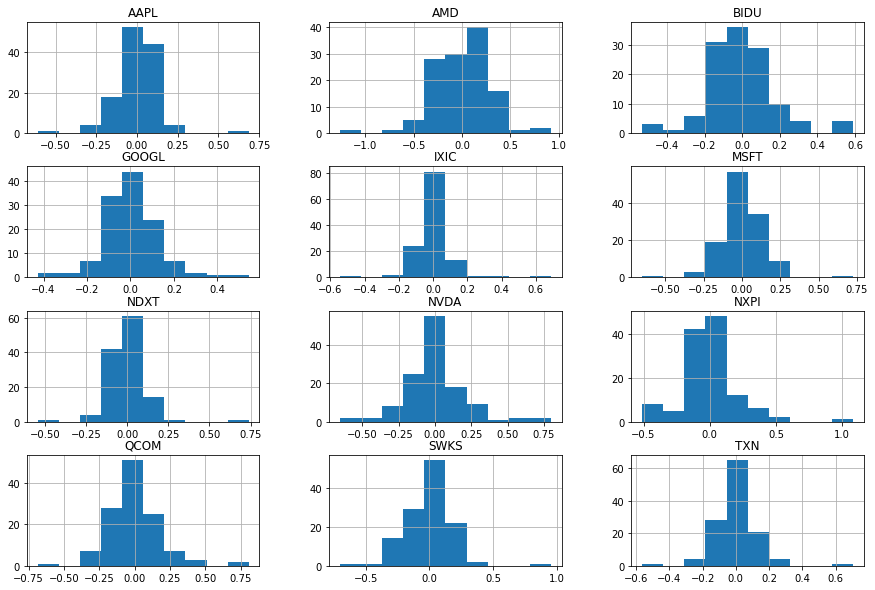

In [74]:
plotdot(volAPE, 20)

#### APE

           APE (Volatility)                                                    \
ticker                 AAPL       AMD      BIDU     GOOGL      IXIC      MSFT   
Date                                                                            
2011-06-29         0.142340  0.584158  0.492660  0.586510  0.072769  0.020635   
2011-07-28         0.532389  0.028605  0.462816  0.036725  0.629553  0.465795   
2011-08-25         0.912651  0.241124  0.306258  1.013063  0.755752  0.394543   
2011-09-23         0.357805  0.278419  0.178909  0.329232  0.047113  0.343969   
2011-10-21         0.395168  0.064057  0.178907  0.452509  0.015375  0.195967   
...                     ...       ...       ...       ...       ...       ...   
2020-12-11         0.354143  0.012954  0.631336  0.073000  0.128371  0.305481   
2021-01-12         0.066458  0.163811  0.685996  0.464978  0.273856  0.092158   
2021-02-10         0.126313  0.259438  0.467453  0.288987  0.373047  0.066426   
2021-03-11         0.431299 

(None,
 array([[<AxesSubplot:title={'center':"('APE (Volatility)', 'AAPL')"}>,
         <AxesSubplot:title={'center':"('APE (Volatility)', 'AMD')"}>,
         <AxesSubplot:title={'center':"('APE (Volatility)', 'BIDU')"}>],
        [<AxesSubplot:title={'center':"('APE (Volatility)', 'GOOGL')"}>,
         <AxesSubplot:title={'center':"('APE (Volatility)', 'IXIC')"}>,
         <AxesSubplot:title={'center':"('APE (Volatility)', 'MSFT')"}>],
        [<AxesSubplot:title={'center':"('APE (Volatility)', 'NDXT')"}>,
         <AxesSubplot:title={'center':"('APE (Volatility)', 'NVDA')"}>,
         <AxesSubplot:title={'center':"('APE (Volatility)', 'NXPI')"}>],
        [<AxesSubplot:title={'center':"('APE (Volatility)', 'QCOM')"}>,
         <AxesSubplot:title={'center':"('APE (Volatility)', 'SWKS')"}>,
         <AxesSubplot:title={'center':"('APE (Volatility)', 'TXN')"}>]],
       dtype=object))

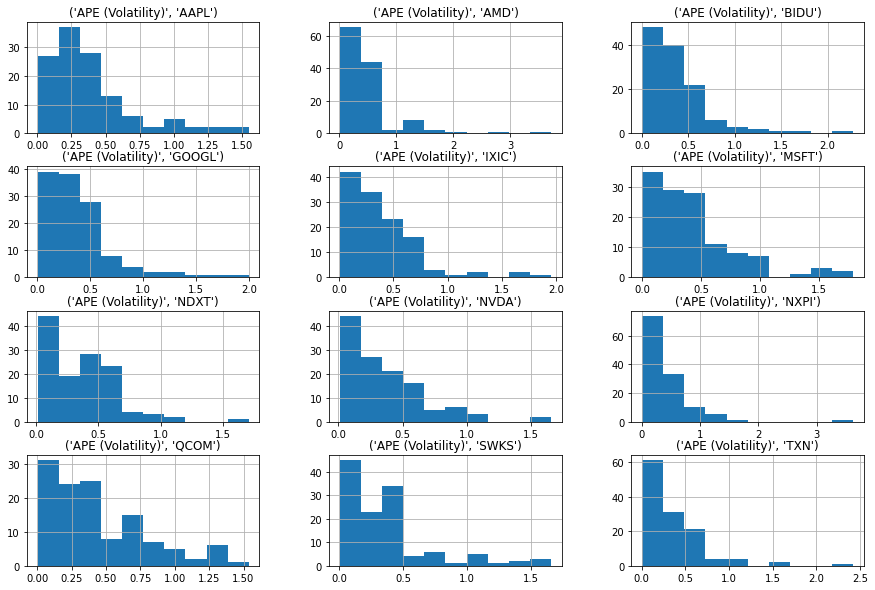

In [73]:
# histogram, tw = 20
plothist(volAPE, 20)
#plothist(volAPE, 20)
#plothist(meanAPE, 70)

In [49]:
# dot plot, volatility, tail = 10%
#plotdot(volAPE, 5, 150, 5, 0.1)

In [38]:
# dot plot, mean, tail = 10%
#plotdot_mean(meanAPE, 5, 150, 5, 0.1)

In [39]:
# dot plot, mean, tail = 50%
#plotdot_mean(meanAPE, 5, 150, 5, 0.5)

In [40]:
# dot plot, mean, tail = 0, 100 (for checking)
#plotdot_mean(meanAPE, 5, 150, 5, 0)
#plotdot_mean(meanAPE, 5, 150, 5, 100)

In [41]:
# dot plot, mean, tail = inf (for checking)
#plotdot_mean(meanAPE, 5, 150, 5, math.inf)

#### AMPE

In [47]:
# histogram, tw = 70
#plothist(volAMPE, 70)
#plothist(meanAMPE, 70)

In [30]:
# dot plot, volatility, tail = 10%
len(volAMPE(logret, 70))

34

Inf error exists when time window = [5, 10, 25, 35, 40]
NaN exists when time window = []


<AxesSubplot:title={'center':'Mean, Percentage of error observations greater than tail=0.5, AMPE'}>

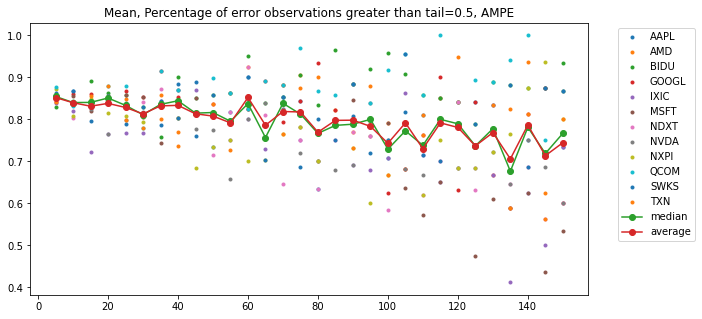

In [97]:
# dot plot, volatility, tail = 50%
plotdot(meanAMPE, 5, 150, 5, 0.5)[3]

Inf error exists when time window = [5, 10, 25, 35, 40]
NaN exists when time window = []


<AxesSubplot:title={'center':'Mean, Percentage of error observations greater than tail=0.1, AMPE'}>

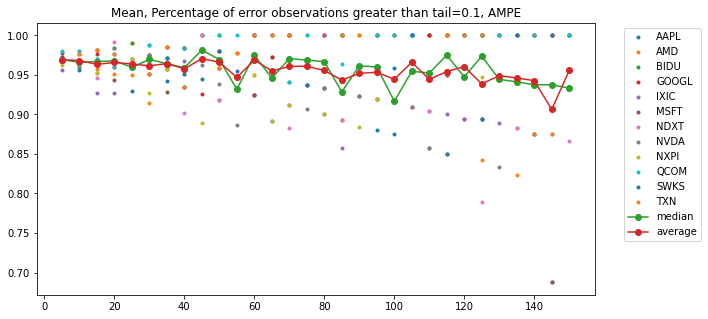

In [64]:
# dot plot, mean, tail = 10%
plotdot(meanAMPE, 5, 150, 5, 0.1)[3]

Inf error exists when time window = [5, 10, 25, 35, 40]
NaN exists when time window = []


<AxesSubplot:title={'center':'Mean, Percentage of error observations greater than tail=0.5, AMPE'}>

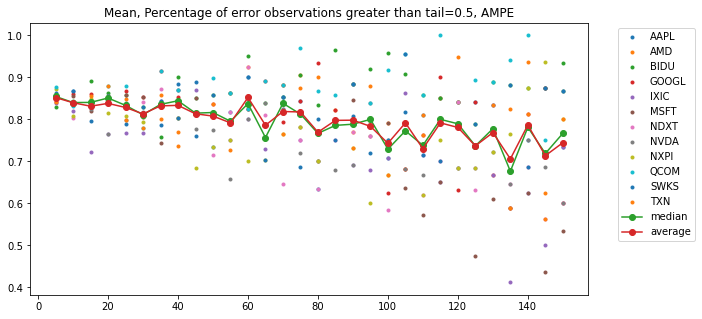

In [65]:
# dot plot, mean, tail = 50%
plotdot(meanAMPE, 5, 150, 5, 0.5)[3]

#### LAAR 

In [15]:
# histogram, tw = 70
#plothist(volLAAR, 70)
#plothist(meanLAAR, 70)

In [18]:
print(volpred(logret, 20))

              Logret                                                    \
ticker          AAPL       AMD      BIDU     GOOGL      IXIC      MSFT   
Date                                                                     
2011-06-29  0.243854  0.312932  0.575892  0.204756  0.181221  0.219093   
2011-07-28  0.213469  0.752527  0.385816  0.495191  0.195443  0.223709   
2011-08-25  0.456510  0.731600  0.718219  0.477649  0.527588  0.418769   
2011-09-23  0.238679  0.589466  0.549829  0.237275  0.300491  0.300292   
2011-10-21  0.371662  0.816909  0.669633  0.353736  0.315348  0.223436   
...              ...       ...       ...       ...       ...       ...   
2021-01-12  0.348787  0.331833  0.937624  0.215430  0.143293  0.223532   
2021-02-10  0.327052  0.396840  0.556125  0.402656  0.197334  0.246224   
2021-03-11  0.374335  0.535863  1.044274  0.312381  0.314750  0.263743   
2021-04-09  0.261535  0.330258  0.776800  0.251842  0.199813  0.241190   
2021-05-07  0.230807  0.451100  0.2857

Inf error exists when time window = []
NaN exists when time window = []


(None,
 None,
 ticker      AAPL           AMD      BIDU     GOOGL      IXIC      MSFT  \
 5       0.222649  3.512100e-02  0.043558  0.153921  0.374783  0.201710   
 10      0.203363  3.398862e-02  0.113287  0.173990  0.393209  0.236895   
 15      0.201158  1.325019e-02  0.084587  0.157182  0.283117  0.132115   
 20      0.169391  3.457992e-02  0.086573  0.101156  0.219372  0.134086   
 25      0.122040  3.735412e-02  0.077595  0.080094  0.185643  0.096275   
 30      0.111813  3.672421e-02  0.207002  0.076840  0.154948  0.083829   
 35      0.117136  7.343798e-02  0.293283  0.108319  0.152174  0.112833   
 40      0.063937  6.537626e-02  0.247297  0.088412  0.088705  0.057016   
 45      0.074659  5.280375e-02  0.214247  0.050948  0.122560  0.076408   
 50      0.049476  8.868861e-02  0.309249  0.030137  0.079281  0.055577   
 55      0.085324  9.442192e-02  0.292139  0.032055  0.074146  0.076704   
 60      0.022614  3.798364e-02  0.089356  0.009102  0.071745  0.032398   
 65      0.

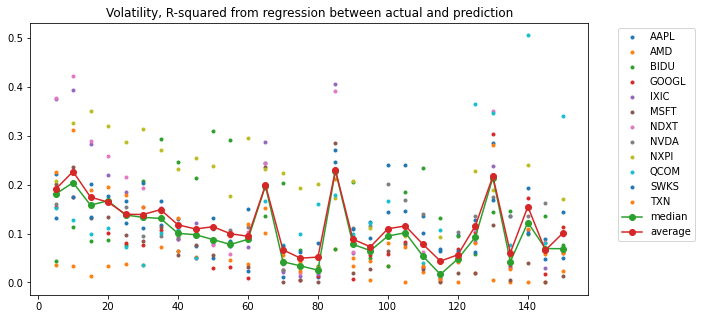

In [98]:
plotr2(volpred, 5, 150, 5)

Inf error exists when time window = []
NaN exists when time window = []


(None,
 None,
 ticker      AAPL       AMD      BIDU         GOOGL      IXIC      MSFT  \
 5       0.000043  0.000347  0.000896  7.415444e-03  0.002735  0.015540   
 10      0.003192  0.000740  0.001226  9.660056e-03  0.003396  0.023549   
 15      0.004875  0.000230  0.001798  1.569691e-02  0.022883  0.008575   
 20      0.005696  0.013373  0.010869  6.761375e-03  0.000089  0.013757   
 25      0.002917  0.003987  0.002041  2.795985e-02  0.013105  0.005294   
 30      0.000074  0.009175  0.004361  6.208925e-02  0.037068  0.050555   
 35      0.000171  0.004873  0.000647  6.734060e-02  0.053755  0.062730   
 40      0.000007  0.016767  0.002598  8.198480e-02  0.005218  0.006480   
 45      0.004395  0.061360  0.004925  9.266666e-02  0.002281  0.069956   
 50      0.006405  0.006567  0.000142  4.126457e-03  0.058610  0.101968   
 55      0.015126  0.022654  0.000311  1.473124e-01  0.014592  0.019032   
 60      0.017208  0.006468  0.005764  1.360286e-01  0.143942  0.165164   
 65      0.

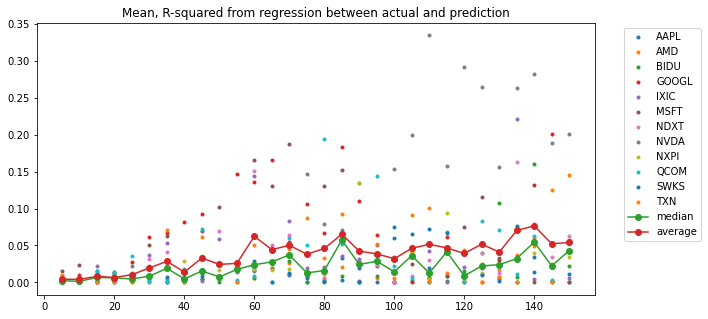

In [99]:
plotr2(meanpred, 5, 150, 5)

In [26]:
df_pred = volpred(logret, 20)
df_act = df_pred.shift(-1)

    df_volpred = volpred(df, n)
    df_volact = df_volpred.shift(-1)
    df_volerr = (df_volpred - df_volact).iloc[:-1]  # delete the last NaN row 
#df_pred = df_pred.iloc[:-1]
#act = df_act.iloc[:,"NXPI"].values.reshape(len(df_act.iloc[:,"NXPI"]), 1)
#pred = df_pred.iloc[:,"NXPI"].values.reshape(len(df_pred.iloc[:,"NXPI"]), 1)
#md = linear_model.LinearRegression()
#md.fit(act, pred)
#r2 = md.score(act, pred)
# fill in r2 into df_r2
print(df_act)

              Logret                                                    \
ticker          AAPL       AMD      BIDU     GOOGL      IXIC      MSFT   
Date                                                                     
2011-06-29  0.213469  0.752527  0.385816  0.495191  0.195443  0.223709   
2011-07-28  0.456510  0.731600  0.718219  0.477649  0.527588  0.418769   
2011-08-25  0.238679  0.589466  0.549829  0.237275  0.300491  0.300292   
2011-09-23  0.371662  0.816909  0.669633  0.353736  0.315348  0.223436   
2011-10-21  0.266392  0.767730  0.568011  0.243534  0.310573  0.277894   
...              ...       ...       ...       ...       ...       ...   
2021-01-12  0.327052  0.396840  0.556125  0.402656  0.197334  0.246224   
2021-02-10  0.374335  0.535863  1.044274  0.312381  0.314750  0.263743   
2021-03-11  0.261535  0.330258  0.776800  0.251842  0.199813  0.241190   
2021-04-09  0.230807  0.451100  0.285786  0.199587  0.150836  0.185188   
2021-05-07       NaN       NaN       N